<a href="https://colab.research.google.com/github/Weverton-Vitor/houseplants-classification-resnet/blob/main/houseplants_classification_resnet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Plant classification using ResNet-34

# 0. Install and Import libs

In [ ]:
import os
import requests
import zipfile
import shutil
import random
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Literal
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 1. Exploring the data and create dataset objects

## 1.1 Getting and formatting the data set

In [ ]:
data_path = './data'
original_path = './house_plant_species'

In [ ]:
!kaggle datasets download -d kacpergregorowicz/house-plant-species

Dataset URL: https://www.kaggle.com/datasets/kacpergregorowicz/house-plant-species
License(s): CC-BY-NC-SA-4.0
100% 4.84G/4.85G [01:20<00:00, 48.0MB/s]
100% 4.85G/4.85G [01:20<00:00, 64.9MB/s]


In [ ]:
# Extract dataset
with zipfile.ZipFile('/content/house-plant-species.zip', 'r') as file_zip:
    file_zip.extractall()

## 1.2 Exploration

In [ ]:
def show_random_species(original_path: str ) -> None:
  plt.figure(figsize=(12, 12))
  for i in range(9):
    specie = random.sample(os.listdir(original_path), k=1)[0]
    image_path = random.sample(os.listdir(f'{original_path}/{specie}'), k=1)[0]

    plt.subplot(3, 3, i+1)
    image = plt.imread(f'{original_path}/{specie}/{image_path}')
    plt.title(specie)
    plt.axis(False)
    plt.imshow(image)

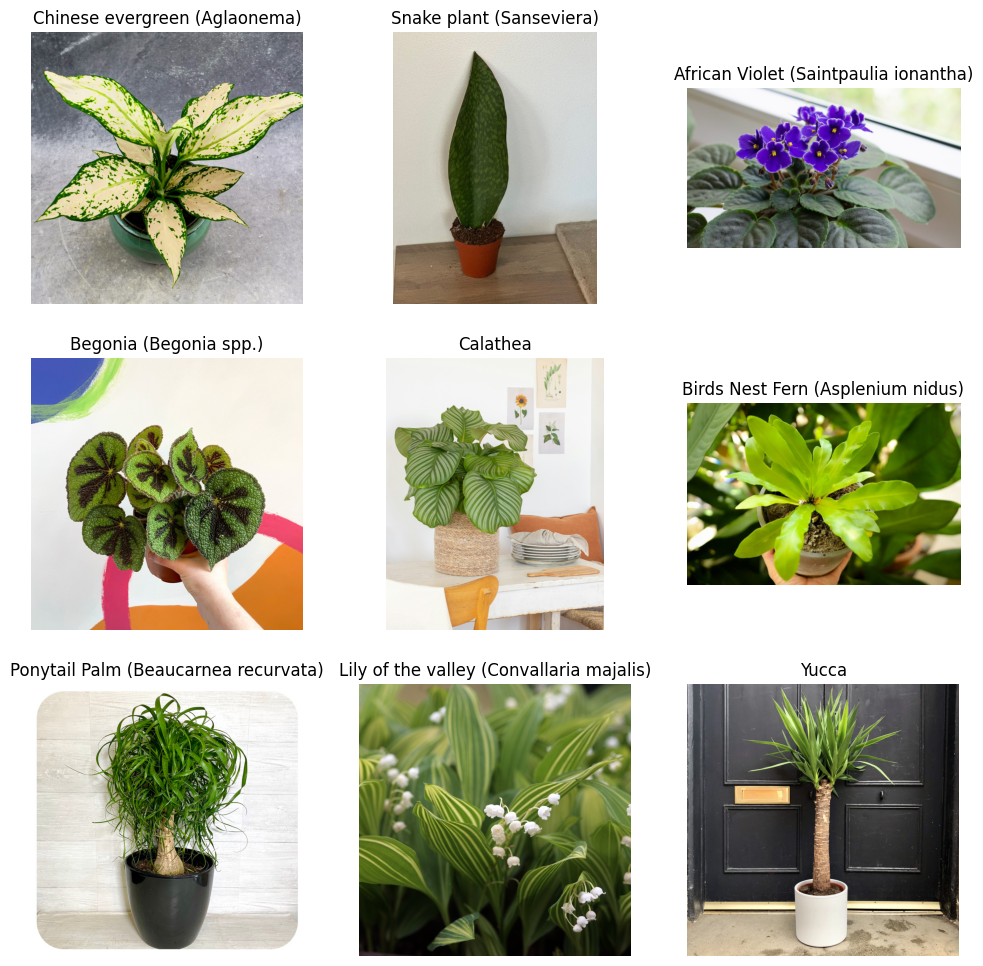

In [ ]:
show_random_species(original_path)

In [ ]:
species_df = pd.DataFrame(columns=['species', 'qty'])
species_df['species'] = os.listdir(original_path)
species_df['qty'] = [len(os.listdir(f"{original_path}/{specie}")) for specie in os.listdir(original_path)]

In [ ]:
species_df[:10]

,species,qty
0,English Ivy (Hedera helix),240
1,Jade plant (Crassula ovata),353
2,ZZ Plant (Zamioculcas zamiifolia),438
3,Begonia (Begonia spp.),236
4,Tulip,341
5,Chinese Money Plant (Pilea peperomioides),382
6,Cast Iron Plant (Aspidistra elatior),266
7,Poinsettia (Euphorbia pulcherrima),306
8,Lily of the valley (Convallaria majalis),416
9,Hyacinth (Hyacinthus orientalis),318


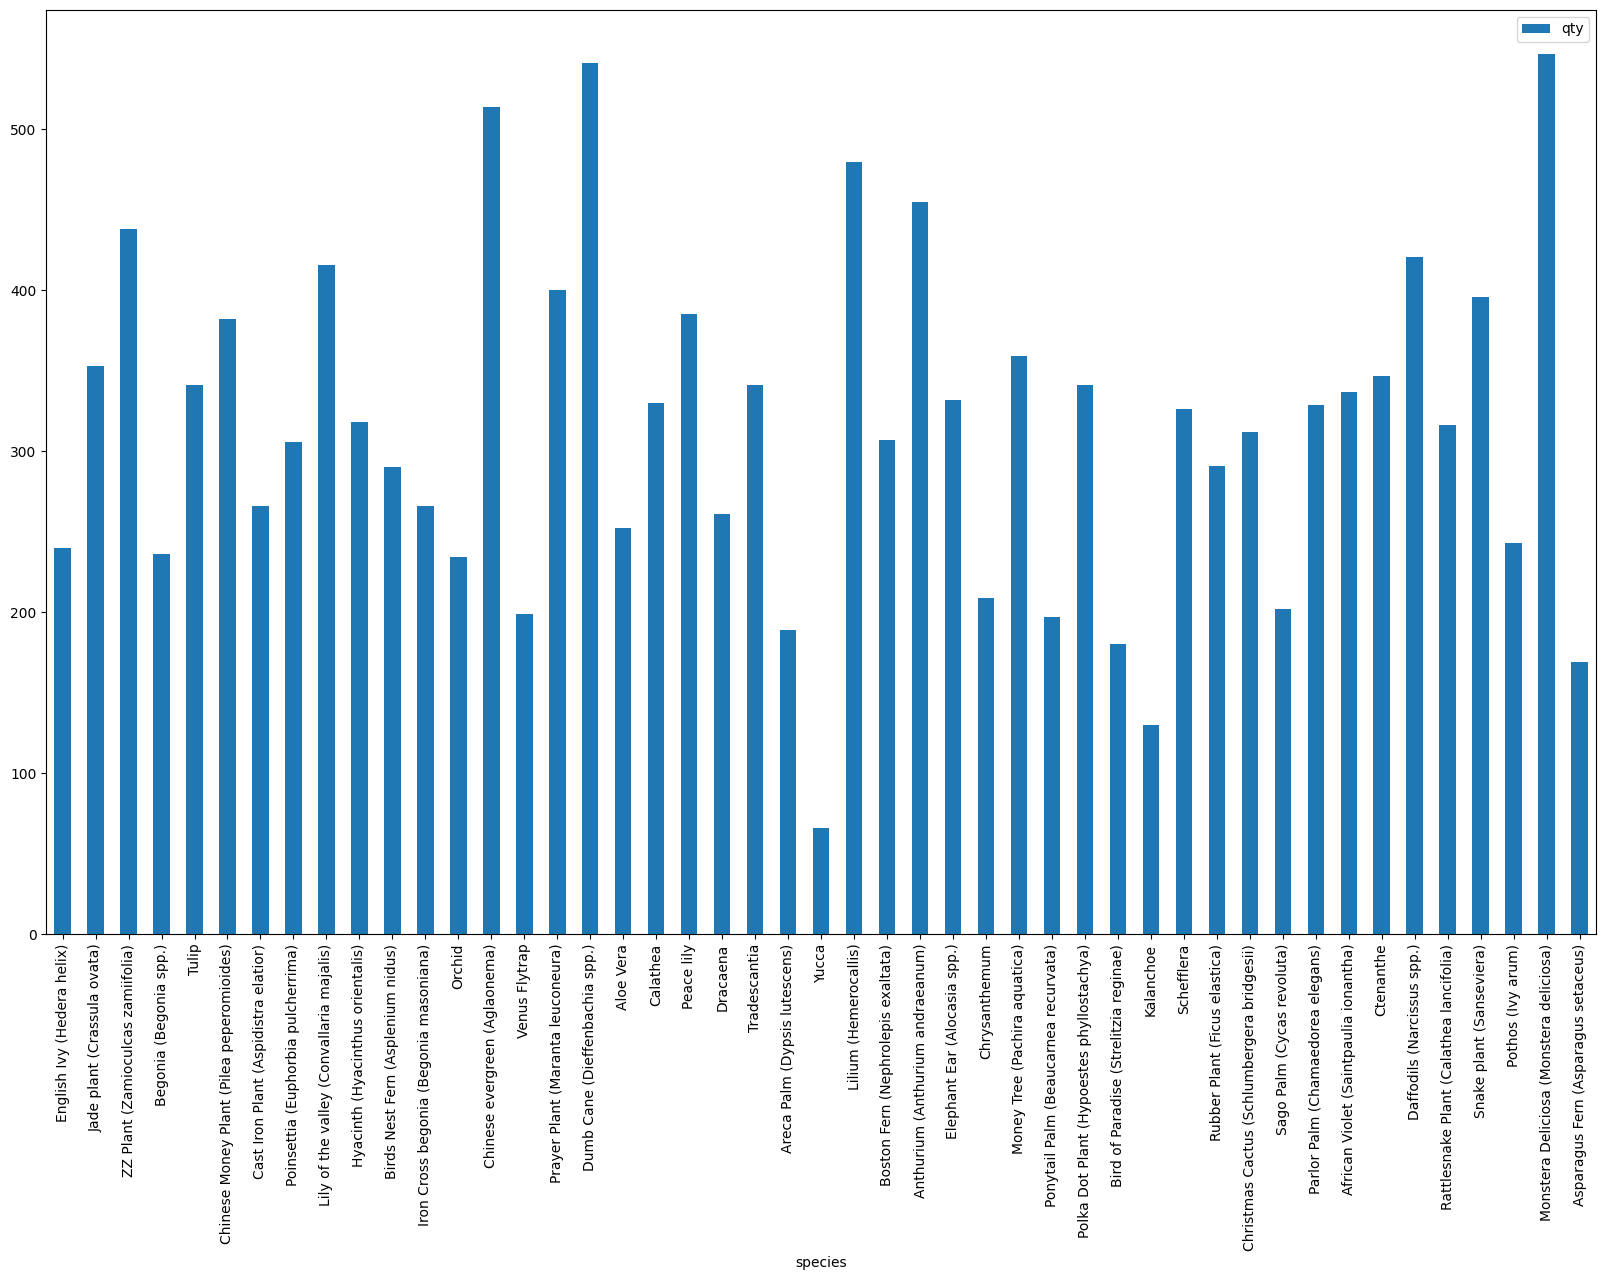

In [ ]:
species_df.plot(kind='bar', x='species', y='qty', figsize=(20, 12));

## 1.3 Formating folder structures to standart classification format
- /imagens
    - /train
      - /class1
      - /class2
      - /...
    - /validation
      - /class1
      - /class2
      - /...
    - /test
      - /class1
      - /class2
      - /...


Sampling will be done using python random.samples

In [ ]:
# Returns a simple version of specie name
def get_specie_name(specie: str) -> str:
  specie_name = specie.split('(')[0].lower().replace(' ', '_')
  return specie_name[:len(specie_name)-1] if specie_name[-1] == '_' else specie_name


def create_dataset_folders(new_path: str, original_path: str) -> None:
  species = os.listdir(original_path)

  # General folders
  os.makedirs(f'{new_path}/train', exist_ok=True)
  os.makedirs(f'{new_path}/test', exist_ok=True)

  # Create folders for each specie
  for dataset in os.listdir(new_path):
      for specie in species:
        os.makedirs(f'{new_path}/{dataset}/{get_specie_name(specie)}', exist_ok=True)

# Random sampling for each catgory and retunrna dict with classes as key
# and test images as value
def get_test_images(path: str, test_size: float) -> Dict[str, str]:
  test_images = {}
  for specie in os.listdir(path):
    qty = len(os.listdir(f'{path}/{specie}'))
    test_qty = int(qty * test_size)
    print(f'{specie}: {qty}, {test_qty}')
    test_samples = random.sample(os.listdir(f'{path}/{specie}'), test_qty)
    test_images[specie] = test_samples

  return test_images

# Move test and train images to respective folders
def move_images(test_images: dict, original_path: str, new_path: str) -> None:

  # Move images test to test folder
  for specie, images in test_images.items():
    for image in images:
      shutil.copy(f'{original_path}/{specie}/{image}', f'{new_path}/test/{get_specie_name(specie)}')

  # Move the rest os images to train folder
  for specie in os.listdir(original_path):
    for image in os.listdir(f'{original_path}/{specie}'):
      shutil.copy(f'{original_path}/{specie}/{image}', f'{new_path}/train/{get_specie_name(specie)}')



In [ ]:
create_dataset_folders(new_path=data_path, original_path=original_path)

test_images = get_test_images(path=original_path, test_size=0.2)

move_images(test_images=test_images,
            original_path=original_path,
            new_path=data_path)



Orchid: 234, 46
Birds Nest Fern (Asplenium nidus): 290, 58
Hyacinth (Hyacinthus orientalis): 318, 63
Poinsettia (Euphorbia pulcherrima): 306, 61
Tradescantia: 341, 68
Lily of the valley (Convallaria majalis): 416, 83
Venus Flytrap: 199, 39
Monstera Deliciosa (Monstera deliciosa): 547, 109
Snake plant (Sanseviera): 396, 79
Begonia (Begonia spp.): 236, 47
Prayer Plant (Maranta leuconeura): 400, 80
Rattlesnake Plant (Calathea lancifolia): 316, 63
Yucca: 66, 13
Parlor Palm (Chamaedorea elegans): 329, 65
Christmas Cactus (Schlumbergera bridgesii): 312, 62
Peace lily: 385, 77
Bird of Paradise (Strelitzia reginae): 180, 36
Anthurium (Anthurium andraeanum): 455, 91
Kalanchoe: 130, 26
Calathea: 330, 66
Dumb Cane (Dieffenbachia spp.): 541, 108
Rubber Plant (Ficus elastica): 291, 58
Chrysanthemum: 209, 41
Money Tree (Pachira aquatica): 359, 71
Jade plant (Crassula ovata): 353, 70
Ctenanthe: 347, 69
Dracaena: 261, 52
Lilium (Hemerocallis): 480, 96
Boston Fern (Nephrolepis exaltata): 307, 61
Areca 

## 1.4 Dataset objects

In [ ]:
train_transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomVerticalFlip(0.5),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomRotation(0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformer = train_transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = ImageFolder(root=f'{data_path}/train', transform=train_transformer)
test_dataset = ImageFolder(root=f'{data_path}/test', transform=test_transformer)

In [ ]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 14774
     Root location: ./data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 2935
     Root location: ./data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [ ]:
 train_dataset[0][0].shape, train_dataset[0]

(torch.Size([3, 224, 224]),
 (tensor([[[ 1.8208,  1.8037,  1.8722,  ...,  1.5468,  1.3413,  1.0331],
           [ 1.8379,  1.9407,  1.9235,  ...,  1.7865,  1.5982,  1.3070],
           [ 1.8550,  1.9407,  1.8379,  ...,  1.8722,  1.7865,  1.5639],
           ...,
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],
  
          [[ 1.9034,  1.9209,  2.0084,  ...,  1.6933,  1.4482,  1.0805],
           [ 1.9209,  2.0609,  2.0434,  ...,  1.9384,  1.7283,  1.4307],
           [ 1.9909,  2.0434,  1.9384,  ...,  2.0084,  1.9034,  1.6758],
           ...,
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],
  
          [[ 2.0648,  2.1346,  2.2217,  ...,  2.0474,  1

## 1.5 Data Loaders

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False)

## 2. ResNet34 import vs ResNet34 from scratch

> Paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385)

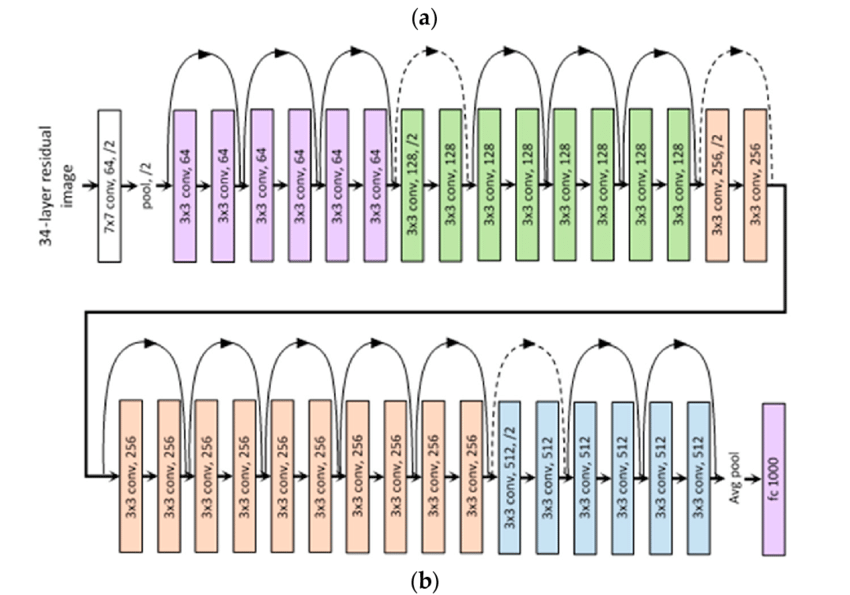

### 2.1 Import Resnet34

In [1]:
from torchvision import models

In [2]:
resnet34 = models.resnet34(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### 2.2 ResNet34 from scratch



#### 2.3 Residual Blocks

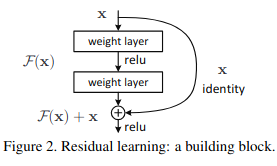 | 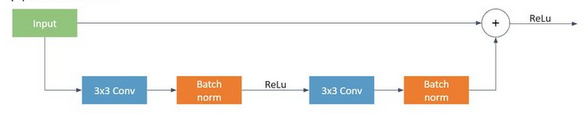

## 3. Training the models